# **Chem277B**: **Machine Learning Algorithms**

## **Homework assignment #7**: Deeper Learning and Regularization

In [44]:
import numpy as np 
import pandas as pd
import math 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import SGD, Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import cycle, islice
from pylab import *
import seaborn as sns
from functools import wraps
from time import time
import random
from tqdm import tqdm
import warnings

sns.set()

## 1. **Bias-variance tradeoff**.

### (a) I have sorted out the training and testing datasets and normalized the data using each 32 * 32 image's maximum pixel value. I noticed some of the image's max pixel value is not 255. I also did a little confirmation test by printing out the sum of the training/testing sets before and after normalization. There's indeed a >200-fold decrease of the sum value.

In [2]:
# First load the mnist data and convert all elements into lists / arrays
mnist = list(pd.read_pickle('mnist.pkl'))
mnist[0] = list(mnist[0])
mnist[1] = list(mnist[1])
train_X = mnist[0][0]
train_y = mnist[0][1]
test_X = mnist[1][0]
test_y = mnist[1][1]
print('Train: X=%s, y=%s' % (train_X.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_y.shape))

Train: X=(60000, 32, 32), y=(60000,)
Test: X=(10000, 32, 32), y=(10000,)


In [3]:
# Define a function to normalize the training and testing data sets
def normalize_pixels(train_X, test_X):
    
    # First convert the dataset to floats
    train_X_norm = train_X.astype('float32')
    test_X_norm = test_X.astype('float32')
    
    # Find maximum values for all 60000 / 10000 pictures in train and test datasets
    # and broadcast to a (60000 / 10000, 32, 32) shape array
    train_X_max = np.broadcast_to(train_X.max(axis=(1,2))[:, np.newaxis, np.newaxis], (60000, 32, 32))
    test_X_max = np.broadcast_to(test_X.max(axis=(1,2))[:, np.newaxis, np.newaxis], (10000, 32, 32))
    
    # Normalize the datasets
    train_X_norm = train_X_norm / train_X_max
    test_X_norm = test_X_norm / test_X_max
    
    # Return the normalized datasets
    return train_X_norm, test_X_norm

In [4]:
# Normalize the datasets and confirm the data has been normalized
train_X_norm, test_X_norm = normalize_pixels(train_X, test_X)
print(train_X.sum(), train_X_norm.sum())
print(test_X.sum(), test_X_norm.sum())

1567298545 6148662.5
264923200 1039329.2


(b) The finished Trainer class and the ANN are shown below.

I divided the training data into a 3-fold groups of training and validation datasets using KFold modality. I chose to do the training-validation split outside the Trainer Class because I found that doing it inside the class always creates index errors and it's very hard to debug. The index errors happened because the for loop to run epoch training first shuffled the indices so some of the large indices will appear and they are outside the index range. I haven't found an elegant way to solve the problem. So I just put the KFold split outside the Trainer Class and it worked just fine.

In [40]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size)
    or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = optim.Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform

    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs, early_stop=False, l2=False, silent=False):
        """ train self.model with specified arguments using 3-fold cross-validation
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """

        ### convert data to tensor of correct shape and type here ###
        inputs = torch.Tensor(self.input_transform(inputs)).float().clone().detach() # inputs are (X (40000), 32, 32))
        outputs = torch.Tensor(outputs).long().clone().detach()  # outputs are (y (40000), ))
        val_inputs = torch.Tensor(self.input_transform(val_inputs)).float().clone().detach() # val_inputs are (X (20000), 32, 32))
        val_outputs = torch.Tensor(val_outputs).long().clone().detach()  # val_outputs are (y (20000), ))
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0])) # range(40000)
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = F.cross_entropy(batch_predictions, batch_output)
                
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_reg = torch.tensor(0.)
                    for param in self.model.parameters():
                        l2_reg += torch.norm(param)
                    loss += l2_lambda * l2_reg
                    
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.item() * batch_importance
                epoch_acc += (batch_predictions.argmax(dim=1) == batch_output).float().mean().item() * batch_importance

            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        with torch.no_grad():
            inputs = torch.tensor(inputs).float().clone().detach()
            outputs = torch.tensor(outputs).long().clone().detach()
            outputs_pred = self.model(inputs)
            loss = F.cross_entropy(outputs_pred, outputs)
            acc = torch.mean((torch.argmax(outputs_pred, dim=1) == outputs).float())
        if print_acc:
            print(f'Accuracy: {acc.item()}')
        return loss, acc

In [29]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 3),
            nn.Sigmoid(),
            nn.Linear(3, 10),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        return self.layers(X)

(c) I made the multi-layer perceptron ANN with 2 computing layers, a hidden layer of 3 neurons and a final output layer of 10 neurons. Both layers use a sigmoid activation function.

I then ran the model using the required ADAM optimizer and parameters. From the results and the generated plots, clearly the model converges without the need or further regularization. But the accuracies are pretty bad and stay at ~0.58. I tested the model on the testing datasets and got similar results on loss and accuracy.

The bias-variance tradeoff refers to the balancing of the model's ability to fit the training data (low bias) with its ability to generalize to new data (low variance).

The MLP ANN we employ here consists of two linear layers with a non-linear activation function in between. The first linear layer maps the input data from a 1024-dimensional space to a 3-dimensional space. The second linear layer maps the output of the first layer from a 3-dimensional space to a 10-dimensional space. The mapping of the space dimension itself is not reasonable as indicated in the tutorial class, gradient vanishing could happen. The hidden layer with 3-dimensions may not provide enough capacity for the model to learn complex patterns in the data.

Hence I think the model's the poor accuracy is due to high bias and limited by the hidden layer and the activation function. The model's variance seems OK but it's limited by the bias.

In [30]:
# Split the dataset into 3-fold training and validation sets
training_result_all = []
kf = KFold(n_splits=3, shuffle=True, random_state=1)
for train_index, val_index in kf.split(train_X_norm, train_y):
    X_train, X_val = train_X_norm[train_index], train_X_norm[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    mlp = MLP()
    ann_1_adam = Trainer(mlp, "adam", 2e-3, 50, 128, input_transform=lambda x: x,)
    # Save model and choose the one with lowest loss and highest accuracy
    training_result = ann_1_adam.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_result_all.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-8-c6373bc9576a>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-8-c6373bc9576a>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  2%|▏         | 1/50 [00:00<00:38,  1.29it/s]

Epoch 1/50 - Loss: 2.206 - Acc: 0.268
              Val_loss: 2.133 - Val_acc: 0.318


 22%|██▏       | 11/50 [00:06<00:20,  1.90it/s]

Epoch 11/50 - Loss: 1.790 - Acc: 0.535
              Val_loss: 1.792 - Val_acc: 0.527


 42%|████▏     | 21/50 [00:11<00:14,  2.04it/s]

Epoch 21/50 - Loss: 1.739 - Acc: 0.504
              Val_loss: 1.748 - Val_acc: 0.490


 62%|██████▏   | 31/50 [00:16<00:11,  1.70it/s]

Epoch 31/50 - Loss: 1.722 - Acc: 0.495
              Val_loss: 1.734 - Val_acc: 0.480


 82%|████████▏ | 41/50 [00:23<00:05,  1.68it/s]

Epoch 41/50 - Loss: 1.707 - Acc: 0.483
              Val_loss: 1.719 - Val_acc: 0.465


func:'train'  took: 29.6902 sec


  2%|▏         | 1/50 [00:00<00:23,  2.07it/s]

Epoch 1/50 - Loss: 1.705 - Acc: 0.473
              Val_loss: 1.699 - Val_acc: 0.485


 22%|██▏       | 11/50 [00:06<00:23,  1.68it/s]

Epoch 11/50 - Loss: 1.696 - Acc: 0.476
              Val_loss: 1.700 - Val_acc: 0.479


 42%|████▏     | 21/50 [00:13<00:25,  1.14it/s]

Epoch 21/50 - Loss: 1.691 - Acc: 0.477
              Val_loss: 1.699 - Val_acc: 0.479


 62%|██████▏   | 31/50 [00:19<00:11,  1.60it/s]

Epoch 31/50 - Loss: 1.686 - Acc: 0.479
              Val_loss: 1.696 - Val_acc: 0.480


 82%|████████▏ | 41/50 [00:25<00:05,  1.71it/s]

Epoch 41/50 - Loss: 1.670 - Acc: 0.480
              Val_loss: 1.682 - Val_acc: 0.480


func:'train'  took: 32.0851 sec


  2%|▏         | 1/50 [00:00<00:23,  2.09it/s]

Epoch 1/50 - Loss: 1.672 - Acc: 0.483
              Val_loss: 1.661 - Val_acc: 0.489


 22%|██▏       | 11/50 [00:06<00:25,  1.56it/s]

Epoch 11/50 - Loss: 1.664 - Acc: 0.506
              Val_loss: 1.664 - Val_acc: 0.505


 42%|████▏     | 21/50 [00:11<00:14,  1.97it/s]

Epoch 21/50 - Loss: 1.660 - Acc: 0.569
              Val_loss: 1.663 - Val_acc: 0.569


 62%|██████▏   | 31/50 [00:18<00:12,  1.52it/s]

Epoch 31/50 - Loss: 1.657 - Acc: 0.580
              Val_loss: 1.663 - Val_acc: 0.580


 82%|████████▏ | 41/50 [00:23<00:04,  2.02it/s]

Epoch 41/50 - Loss: 1.655 - Acc: 0.583
              Val_loss: 1.664 - Val_acc: 0.579


func:'train'  took: 28.4268 sec


In [31]:
ann_1_adam.evaluate(test_X_norm, test_y)

Accuracy: 0.5806999802589417


(tensor(1.6666), tensor(0.5807))

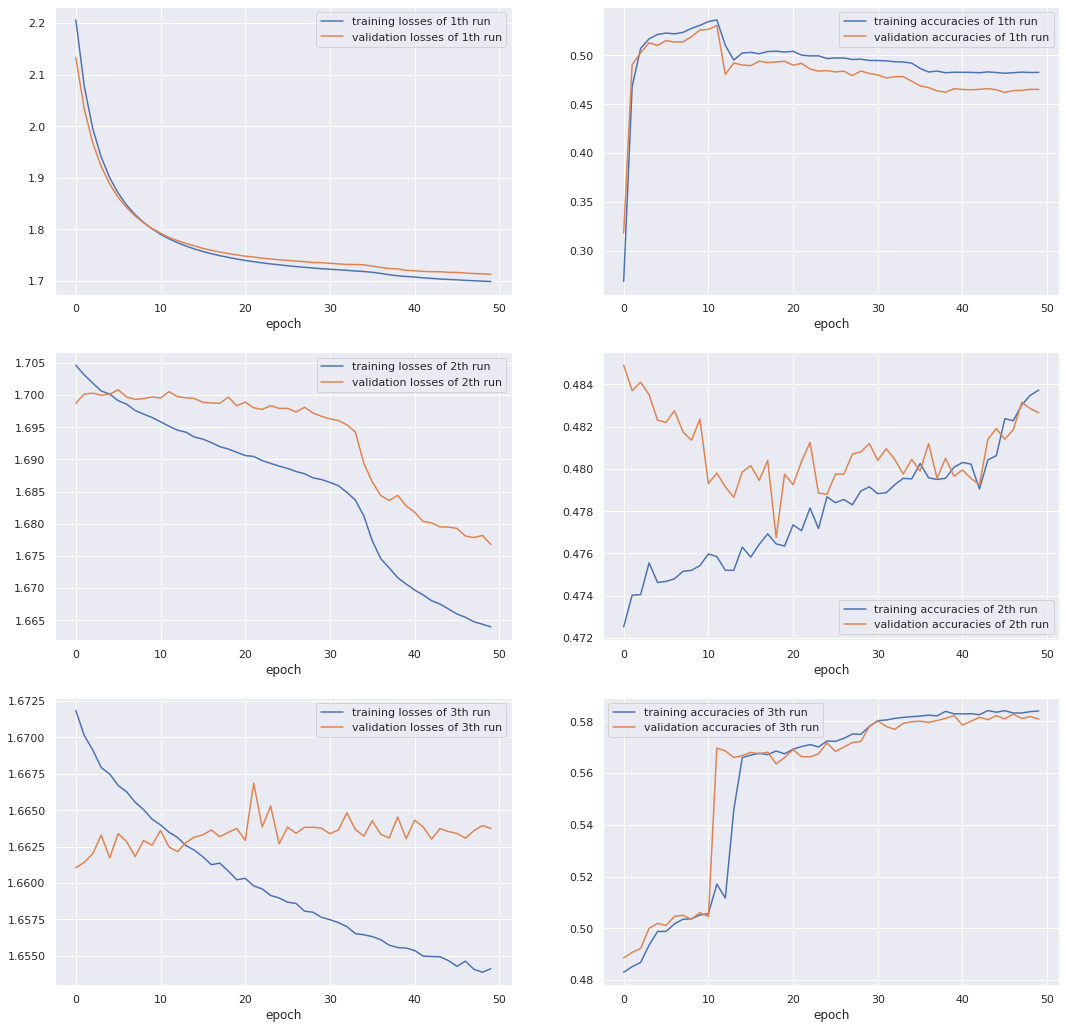

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(18,18))
for i in range(len(training_result_all)):
    axes[i][0].plot(training_result_all[i]["losses"], label = f"training losses of {i+1}th run")
    axes[i][0].plot(training_result_all[i]["val_losses"], label = f"validation losses of {i+1}th run")
    axes[i][0].legend()
    axes[i][0].set_xlabel('epoch')
    axes[i][1].plot(training_result_all[i]["accuracies"], label = f"training accuracies of {i+1}th run")
    axes[i][1].plot(training_result_all[i]["val_accuracies"], label = f"validation accuracies of {i+1}th run")
    axes[i][1].legend()
    axes[i][1].set_xlabel('epoch') 

(d) After increasing the hidden layer size from 3 to 50, I noticed 2 big differences: 1) the training accuracies increased a lot from 0.5 to 0.98; 2) the training time is much longer, increasing from ~30 seconds to ~40 seconds.

In total the bias of the new model is significantly lower and it applies to the testing dataset very well too.

From what I read, the hidden layer size can affect the bias because it determines the number of parameters that the model can learn. In general a larger hidden layer size allows the model to learn more complex representations of the input data. Hence it allows the ANN model to capture paterns and relationships in the data. But the bias-variance tradeoff could start to happen when the hidden layer size is too large and leads to overfitting.

In this case, after increasing the hidden layer size from 3 to 50, both bias and variance improve on training, validation and testing datasets. I haven't found any indication of overfitting yet.



In [33]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        return self.layers(X)

In [34]:
mlp2 = MLP2()
ann_2_adam = Trainer(mlp2, "adam", 2e-3, 50, 128, input_transform=lambda x: x,)

# Split the dataset into 3-fold training and validation sets
training_result_all = []
kf = KFold(n_splits=3, shuffle=True, random_state=1)
for train_index, val_index in kf.split(train_X_norm, train_y):
    X_train, X_val = train_X_norm[train_index], train_X_norm[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = ann_2_adam.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_result_all.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-8-c6373bc9576a>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-8-c6373bc9576a>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  2%|▏         | 1/50 [00:01<01:06,  1.36s/it]

Epoch 1/50 - Loss: 1.824 - Acc: 0.793
              Val_loss: 1.649 - Val_acc: 0.888


 22%|██▏       | 11/50 [00:09<00:33,  1.17it/s]

Epoch 11/50 - Loss: 1.511 - Acc: 0.952
              Val_loss: 1.521 - Val_acc: 0.939


 42%|████▏     | 21/50 [00:17<00:22,  1.28it/s]

Epoch 21/50 - Loss: 1.493 - Acc: 0.968
              Val_loss: 1.511 - Val_acc: 0.948


 62%|██████▏   | 31/50 [00:26<00:14,  1.29it/s]

Epoch 31/50 - Loss: 1.484 - Acc: 0.975
              Val_loss: 1.508 - Val_acc: 0.953


 82%|████████▏ | 41/50 [00:34<00:07,  1.18it/s]

Epoch 41/50 - Loss: 1.479 - Acc: 0.980
              Val_loss: 1.508 - Val_acc: 0.954


func:'train'  took: 41.5278 sec


  2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

Epoch 1/50 - Loss: 1.492 - Acc: 0.968
              Val_loss: 1.481 - Val_acc: 0.979


 22%|██▏       | 11/50 [00:09<00:30,  1.29it/s]

Epoch 11/50 - Loss: 1.479 - Acc: 0.979
              Val_loss: 1.484 - Val_acc: 0.977


 42%|████▏     | 21/50 [00:18<00:25,  1.13it/s]

Epoch 21/50 - Loss: 1.476 - Acc: 0.982
              Val_loss: 1.486 - Val_acc: 0.975


 62%|██████▏   | 31/50 [00:28<00:20,  1.09s/it]

Epoch 31/50 - Loss: 1.474 - Acc: 0.984
              Val_loss: 1.489 - Val_acc: 0.973


 82%|████████▏ | 41/50 [00:36<00:07,  1.28it/s]

Epoch 41/50 - Loss: 1.473 - Acc: 0.985
              Val_loss: 1.491 - Val_acc: 0.972


func:'train'  took: 45.3296 sec


  2%|▏         | 1/50 [00:00<00:37,  1.32it/s]

Epoch 1/50 - Loss: 1.484 - Acc: 0.977
              Val_loss: 1.475 - Val_acc: 0.986


 22%|██▏       | 11/50 [00:09<00:35,  1.10it/s]

Epoch 11/50 - Loss: 1.475 - Acc: 0.983
              Val_loss: 1.474 - Val_acc: 0.987


 42%|████▏     | 21/50 [00:17<00:22,  1.28it/s]

Epoch 21/50 - Loss: 1.473 - Acc: 0.984
              Val_loss: 1.476 - Val_acc: 0.986


 62%|██████▏   | 31/50 [00:25<00:15,  1.22it/s]

Epoch 31/50 - Loss: 1.473 - Acc: 0.985
              Val_loss: 1.478 - Val_acc: 0.984


 82%|████████▏ | 41/50 [00:34<00:08,  1.08it/s]

Epoch 41/50 - Loss: 1.472 - Acc: 0.986
              Val_loss: 1.480 - Val_acc: 0.983


func:'train'  took: 42.0510 sec


In [35]:
ann_2_adam.evaluate(test_X_norm, test_y)

Accuracy: 0.9611999988555908


(tensor(1.5040), tensor(0.9612))

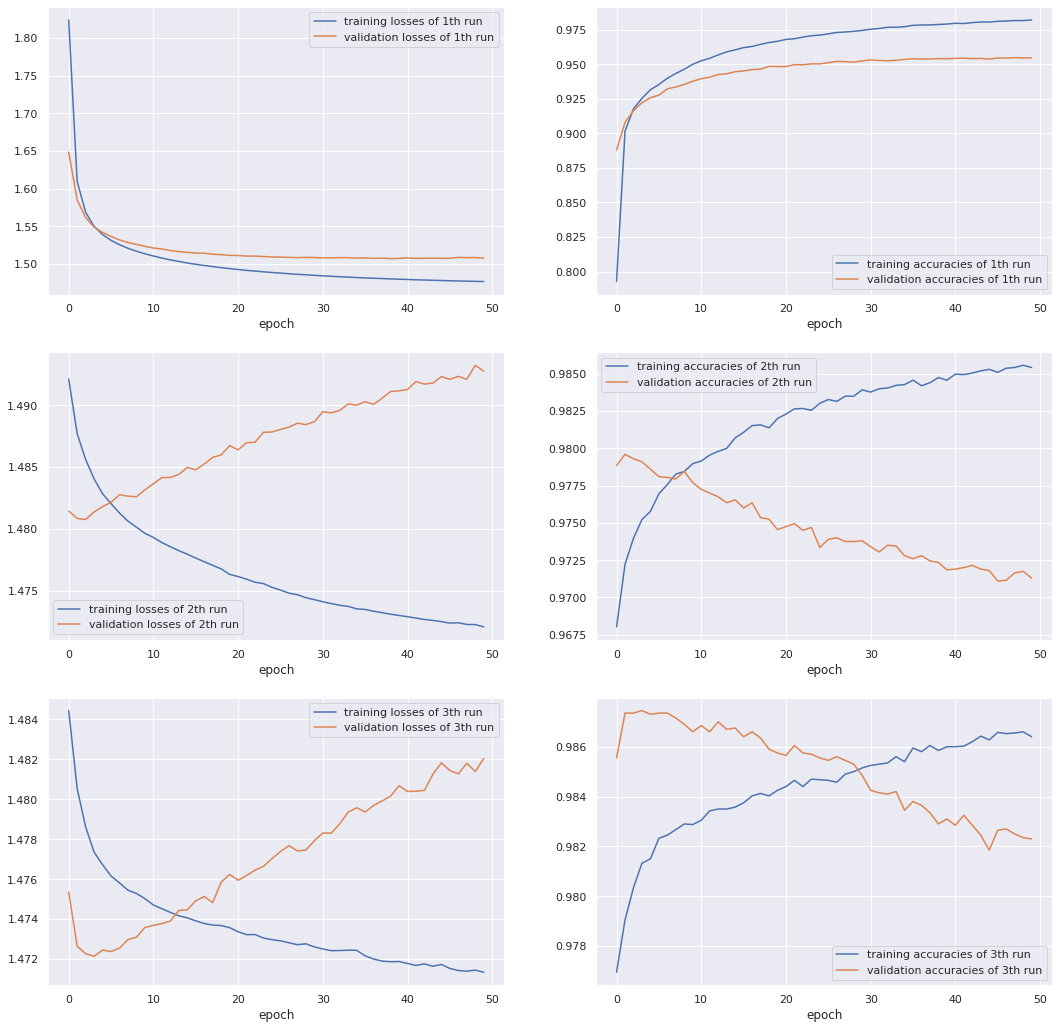

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(18,18))
for i in range(len(training_result_all)):
    axes[i][0].plot(training_result_all[i]["losses"], label = f"training losses of {i+1}th run")
    axes[i][0].plot(training_result_all[i]["val_losses"], label = f"validation losses of {i+1}th run")
    axes[i][0].legend()
    axes[i][0].set_xlabel('epoch')
    axes[i][1].plot(training_result_all[i]["accuracies"], label = f"training accuracies of {i+1}th run")
    axes[i][1].plot(training_result_all[i]["val_accuracies"], label = f"validation accuracies of {i+1}th run")
    axes[i][1].legend()
    axes[i][1].set_xlabel('epoch') 

## 2. **Deep Learning and regularization**.

(a) I modified the ANN and added a dropout layer with 15% probability after the hidden layer. From what I read and the tutorial this is to prevent overfitting. The end result is actually worse than the ANN without the dropout layer. I have tabulated the training / validation / test accuracies below.

Category | Training Accuracy | Validation Accuracy | Test Accuracy | Run Time(seconds)
--- | --- | --- | --- | ---
1c: Hidden Layer=3 | 0.583 | 0.579 | 0.581 | 28.4
1d: Hidden Layer=50 | 0.986 | 0.983 | 0.961 | 42.1
2a: 1d + 15% dropout | 0.976 | 0.970 | 0.956 | 43.6

From the comparison, it's very clear that 15% dropout didn't really help the accuracy and the application to test accuracy. Which is consistent with 1d's observation that the ANN is not overfitting yet. The run time actually increased a little likely due to the random dropping step.

In [37]:
class MLP2_dropout(nn.Module):
    def __init__(self):
        super(MLP2_dropout, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 50),
            nn.Sigmoid(),

            # Add a dropout layer with 15% probability
            nn.Dropout(p=0.15),

            nn.Linear(50, 10),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        return self.layers(X)

In [38]:
mlp2_dropout = MLP2_dropout()
ann_3_adam = Trainer(mlp2_dropout, "adam", 2e-3, 50, 128, input_transform=lambda x: x,)

# Split the dataset into 3-fold training and validation sets
training_result_all = []
kf = KFold(n_splits=3, shuffle=True, random_state=1)
for train_index, val_index in kf.split(train_X_norm, train_y):
    X_train, X_val = train_X_norm[train_index], train_X_norm[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = ann_3_adam.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_result_all.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-8-c6373bc9576a>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-8-c6373bc9576a>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  2%|▏         | 1/50 [00:01<00:50,  1.03s/it]

Epoch 1/50 - Loss: 1.839 - Acc: 0.777
              Val_loss: 1.662 - Val_acc: 0.874


 22%|██▏       | 11/50 [00:09<00:31,  1.25it/s]

Epoch 11/50 - Loss: 1.522 - Acc: 0.943
              Val_loss: 1.530 - Val_acc: 0.934


 42%|████▏     | 21/50 [00:18<00:27,  1.05it/s]

Epoch 21/50 - Loss: 1.506 - Acc: 0.957
              Val_loss: 1.519 - Val_acc: 0.941


 62%|██████▏   | 31/50 [00:28<00:16,  1.14it/s]

Epoch 31/50 - Loss: 1.498 - Acc: 0.963
              Val_loss: 1.515 - Val_acc: 0.945


 82%|████████▏ | 41/50 [00:37<00:08,  1.05it/s]

Epoch 41/50 - Loss: 1.493 - Acc: 0.969
              Val_loss: 1.512 - Val_acc: 0.947


func:'train'  took: 44.6958 sec


  2%|▏         | 1/50 [00:00<00:40,  1.21it/s]

Epoch 1/50 - Loss: 1.500 - Acc: 0.960
              Val_loss: 1.493 - Val_acc: 0.968


 22%|██▏       | 11/50 [00:09<00:34,  1.14it/s]

Epoch 11/50 - Loss: 1.493 - Acc: 0.967
              Val_loss: 1.496 - Val_acc: 0.964


 42%|████▏     | 21/50 [00:18<00:27,  1.05it/s]

Epoch 21/50 - Loss: 1.489 - Acc: 0.971
              Val_loss: 1.498 - Val_acc: 0.962


 62%|██████▏   | 31/50 [00:27<00:15,  1.23it/s]

Epoch 31/50 - Loss: 1.487 - Acc: 0.973
              Val_loss: 1.498 - Val_acc: 0.962


 82%|████████▏ | 41/50 [00:35<00:07,  1.25it/s]

Epoch 41/50 - Loss: 1.486 - Acc: 0.975
              Val_loss: 1.500 - Val_acc: 0.960


func:'train'  took: 44.1680 sec


  2%|▏         | 1/50 [00:00<00:39,  1.24it/s]

Epoch 1/50 - Loss: 1.493 - Acc: 0.967
              Val_loss: 1.484 - Val_acc: 0.978


 22%|██▏       | 11/50 [00:08<00:31,  1.23it/s]

Epoch 11/50 - Loss: 1.488 - Acc: 0.971
              Val_loss: 1.485 - Val_acc: 0.976


 42%|████▏     | 21/50 [00:17<00:23,  1.23it/s]

Epoch 21/50 - Loss: 1.486 - Acc: 0.975
              Val_loss: 1.487 - Val_acc: 0.975


 62%|██████▏   | 31/50 [00:26<00:16,  1.12it/s]

Epoch 31/50 - Loss: 1.485 - Acc: 0.975
              Val_loss: 1.489 - Val_acc: 0.971


 82%|████████▏ | 41/50 [00:35<00:09,  1.03s/it]

Epoch 41/50 - Loss: 1.483 - Acc: 0.976
              Val_loss: 1.491 - Val_acc: 0.970


func:'train'  took: 43.6335 sec


In [39]:
ann_3_adam.evaluate(test_X_norm, test_y)

Accuracy: 0.9559999704360962


(tensor(1.5065), tensor(0.9560))

(b) From the tabulated results, l2 regularization improved the accuracy a little (maybe not significant), but increased the run time by almost 2X.

Category | Training Accuracy | Validation Accuracy | Test Accuracy | Run Time(seconds)
--- | --- | --- | --- | ---
1c: Hidden Layer=3 | 0.583 | 0.579 | 0.581 | 28.4
1d: Hidden Layer=50 | 0.986 | 0.983 | 0.961 | 42.1
2a: 1d + 15% dropout | 0.976 | 0.970 | 0.956 | 43.6
2b: 1d + l2 | 0.988 | 0.988 | 0.962 | 78.9

From what I read, L2 regularization adds a penalty term to the loss function of the neural network to penalize the weights if they are too large. This method helps prevent overfitting by reducing the complexity of the model and promoting weight values that are more generalizable. But the step of adding regularization increases the training and computation complexity. The loss function with regularization now needs to be computed and backpropagated in each epoch / batch.

In our case, the benefit of adding L2 regularization doesn't seem very big. Likely because the ANN is not overfitting.

In [41]:
ann_2_adam_l2 = Trainer(mlp2, "adam", 2e-3, 50, 128, input_transform=lambda x: x,)

# Split the dataset into 3-fold training and validation sets
training_result_all = []
kf = KFold(n_splits=3, shuffle=True, random_state=1)
for train_index, val_index in kf.split(train_X_norm, train_y):
    X_train, X_val = train_X_norm[train_index], train_X_norm[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = ann_2_adam_l2.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=True, silent=False)
    training_result_all.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-40-58e0eb1bad63>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-40-58e0eb1bad63>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  2%|▏         | 1/50 [00:01<00:55,  1.12s/it]

Epoch 1/50 - Loss: 1.479 - Acc: 0.985
              Val_loss: 1.472 - Val_acc: 0.987


 22%|██▏       | 11/50 [00:10<00:36,  1.07it/s]

Epoch 11/50 - Loss: 1.474 - Acc: 0.987
              Val_loss: 1.474 - Val_acc: 0.985


 42%|████▏     | 21/50 [00:23<00:39,  1.35s/it]

Epoch 21/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.476 - Val_acc: 0.984


 62%|██████▏   | 31/50 [00:36<00:25,  1.33s/it]

Epoch 31/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.479 - Val_acc: 0.983


 82%|████████▏ | 41/50 [00:49<00:11,  1.31s/it]

Epoch 41/50 - Loss: 1.472 - Acc: 0.988
              Val_loss: 1.481 - Val_acc: 0.982


func:'train'  took: 62.0513 sec


  2%|▏         | 1/50 [00:01<01:01,  1.26s/it]

Epoch 1/50 - Loss: 1.480 - Acc: 0.984
              Val_loss: 1.473 - Val_acc: 0.988


 22%|██▏       | 11/50 [00:14<00:51,  1.32s/it]

Epoch 11/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.473 - Val_acc: 0.988


 42%|████▏     | 21/50 [00:28<00:38,  1.33s/it]

Epoch 21/50 - Loss: 1.472 - Acc: 0.988
              Val_loss: 1.475 - Val_acc: 0.986


 62%|██████▏   | 31/50 [00:45<00:38,  2.04s/it]

Epoch 31/50 - Loss: 1.472 - Acc: 0.989
              Val_loss: 1.477 - Val_acc: 0.985


 82%|████████▏ | 41/50 [01:00<00:13,  1.56s/it]

Epoch 41/50 - Loss: 1.472 - Acc: 0.989
              Val_loss: 1.479 - Val_acc: 0.984


func:'train'  took: 74.8374 sec


  2%|▏         | 1/50 [00:01<01:10,  1.45s/it]

Epoch 1/50 - Loss: 1.479 - Acc: 0.984
              Val_loss: 1.470 - Val_acc: 0.990


 22%|██▏       | 11/50 [00:16<00:55,  1.42s/it]

Epoch 11/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.470 - Val_acc: 0.990


 42%|████▏     | 21/50 [00:31<00:44,  1.55s/it]

Epoch 21/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.471 - Val_acc: 0.989


 62%|██████▏   | 31/50 [00:46<00:30,  1.59s/it]

Epoch 31/50 - Loss: 1.473 - Acc: 0.988
              Val_loss: 1.473 - Val_acc: 0.989


 82%|████████▏ | 41/50 [01:03<00:15,  1.67s/it]

Epoch 41/50 - Loss: 1.472 - Acc: 0.988
              Val_loss: 1.475 - Val_acc: 0.988


func:'train'  took: 78.8620 sec


In [43]:
ann_2_adam_l2.evaluate(test_X_norm, test_y)

Accuracy: 0.9623000025749207


(tensor(1.5031), tensor(0.9623))

(c) I used pca to transform the Train_X_norm dataset with 99% variance kept. Then I fit the pca model to the test_X_norm dataset. The features decreased from 1024 to 331. I modified the ANN model and changed the 1st layer from 1024 to 331 then ran the training.

The results are summarized below:


Category | Training Accuracy | Validation Accuracy | Test Accuracy | Run Time(seconds)
--- | --- | --- | --- | ---
1c: Hidden Layer=3 | 0.583 | 0.579 | 0.581 | 28.4
1d: Hidden Layer=50 | 0.986 | 0.983 | 0.961 | 42.1
2a: 1d + 15% dropout | 0.976 | 0.970 | 0.956 | 43.6
2b: 1d + l2 | 0.988 | 0.988 | 0.962 | 78.9
2c: 1d + pca | 0.981 | 0.980 | 0.955 | 24.2

Overall the pca method works almost as well as the original ANN from 1d. The time is much shorter now because we have less features to fit. The accuracies are comparable. I think it's a good data transformation technique.

In [59]:
pca = PCA(0.99)
train_X_pca = pca.fit_transform(train_X_norm.reshape(60000, 1024))
test_X_pca = pca.transform(test_X_norm.reshape(10000, 1024))
print("train_X shape after PCA transformation: ", train_X_pca.shape)
print("test_X shape after PCA transformation: ", test_X_pca.shape)

train_X shape after PCA transformation:  (60000, 331)
test_X shape after PCA transformation:  (10000, 331)


In [61]:
class MLP2_pca(nn.Module):
    def __init__(self):
        super(MLP2_pca, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(331, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        return self.layers(X)

In [62]:
MLP2_pca = MLP2_pca()
ann_2_adam_pca = Trainer(MLP2_pca, "adam", 2e-3, 50, 128, input_transform=lambda x: x,)

# Split the dataset into 3-fold training and validation sets
training_result_all = []
kf = KFold(n_splits=3, shuffle=True, random_state=1)
for train_index, val_index in kf.split(train_X_pca, train_y):
    X_train, X_val = train_X_pca[train_index], train_X_pca[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = ann_2_adam_pca.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_result_all.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-40-58e0eb1bad63>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-40-58e0eb1bad63>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

Epoch 1/50 - Loss: 1.933 - Acc: 0.774
              Val_loss: 1.688 - Val_acc: 0.887


 22%|██▏       | 11/50 [00:05<00:17,  2.17it/s]

Epoch 11/50 - Loss: 1.518 - Acc: 0.947
              Val_loss: 1.531 - Val_acc: 0.933


 42%|████▏     | 21/50 [00:09<00:12,  2.35it/s]

Epoch 21/50 - Loss: 1.498 - Acc: 0.962
              Val_loss: 1.521 - Val_acc: 0.941


 62%|██████▏   | 31/50 [00:14<00:08,  2.19it/s]

Epoch 31/50 - Loss: 1.489 - Acc: 0.970
              Val_loss: 1.518 - Val_acc: 0.944


 82%|████████▏ | 41/50 [00:19<00:03,  2.26it/s]

Epoch 41/50 - Loss: 1.483 - Acc: 0.975
              Val_loss: 1.518 - Val_acc: 0.945


func:'train'  took: 22.9156 sec


  2%|▏         | 1/50 [00:00<00:21,  2.31it/s]

Epoch 1/50 - Loss: 1.497 - Acc: 0.963
              Val_loss: 1.484 - Val_acc: 0.976


 22%|██▏       | 11/50 [00:05<00:21,  1.85it/s]

Epoch 11/50 - Loss: 1.483 - Acc: 0.975
              Val_loss: 1.489 - Val_acc: 0.973


 42%|████▏     | 21/50 [00:09<00:12,  2.33it/s]

Epoch 21/50 - Loss: 1.479 - Acc: 0.978
              Val_loss: 1.495 - Val_acc: 0.969


 62%|██████▏   | 31/50 [00:13<00:07,  2.38it/s]

Epoch 31/50 - Loss: 1.477 - Acc: 0.980
              Val_loss: 1.499 - Val_acc: 0.966


 82%|████████▏ | 41/50 [00:18<00:04,  1.91it/s]

Epoch 41/50 - Loss: 1.476 - Acc: 0.981
              Val_loss: 1.502 - Val_acc: 0.964


func:'train'  took: 22.9999 sec


  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

Epoch 1/50 - Loss: 1.490 - Acc: 0.970
              Val_loss: 1.474 - Val_acc: 0.986


 22%|██▏       | 11/50 [00:04<00:16,  2.37it/s]

Epoch 11/50 - Loss: 1.479 - Acc: 0.978
              Val_loss: 1.475 - Val_acc: 0.985


 42%|████▏     | 21/50 [00:11<00:13,  2.13it/s]

Epoch 21/50 - Loss: 1.477 - Acc: 0.979
              Val_loss: 1.479 - Val_acc: 0.983


 62%|██████▏   | 31/50 [00:15<00:08,  2.35it/s]

Epoch 31/50 - Loss: 1.476 - Acc: 0.981
              Val_loss: 1.483 - Val_acc: 0.982


 82%|████████▏ | 41/50 [00:20<00:04,  1.82it/s]

Epoch 41/50 - Loss: 1.476 - Acc: 0.981
              Val_loss: 1.486 - Val_acc: 0.980


func:'train'  took: 24.2085 sec


In [63]:
ann_2_adam_pca.evaluate(test_X_pca, test_y)

Accuracy: 0.9545000195503235


(tensor(1.5128), tensor(0.9545))

(d) I chose L2 regularization + PCA transformation. The results are summarized below:


Category | Training Accuracy | Validation Accuracy | Test Accuracy | Run Time(seconds)
--- | --- | --- | --- | ---
1c: Hidden Layer=3 | 0.583 | 0.579 | 0.581 | 28.4
1d: Hidden Layer=50 | 0.986 | 0.983 | 0.961 | 42.1
2a: 1d + 15% dropout | 0.976 | 0.970 | 0.956 | 43.6
2b: 1d + l2 | 0.988 | 0.988 | 0.962 | 78.9
2c: 1d + pca | 0.981 | 0.980 | 0.955 | 24.2
2d: 1d + l2 + pca | 0.986 | 0.9802 | 0.958 | 28.6

Overall the combination of L2 regularization and PCA data transformation gives very good results. The training is faster than both 1d and 2b cases. The accuracies are also very decent. In general this approach combines the benefits of both L2 regularization and the PCA transformation.

In [66]:
ann_2_adam_l2_pca = Trainer(MLP2_pca, "adam", 2e-3, 50, 128, input_transform=lambda x: x,)

# Split the dataset into 3-fold training and validation sets
training_result_all = []
kf = KFold(n_splits=3, shuffle=True, random_state=1)
for train_index, val_index in kf.split(train_X_pca, train_y):
    X_train, X_val = train_X_pca[train_index], train_X_pca[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = ann_2_adam_l2_pca.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=True, silent=False)
    training_result_all.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-40-58e0eb1bad63>:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().clone().detach()
<ipython-input-40-58e0eb1bad63>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs).long().clone().detach()
  2%|▏         | 1/50 [00:00<00:30,  1.60it/s]

Epoch 1/50 - Loss: 1.482 - Acc: 0.981
              Val_loss: 1.474 - Val_acc: 0.984


 22%|██▏       | 11/50 [00:07<00:22,  1.77it/s]

Epoch 11/50 - Loss: 1.475 - Acc: 0.985
              Val_loss: 1.475 - Val_acc: 0.984


 42%|████▏     | 21/50 [00:12<00:15,  1.85it/s]

Epoch 21/50 - Loss: 1.474 - Acc: 0.986
              Val_loss: 1.479 - Val_acc: 0.982


 62%|██████▏   | 31/50 [00:18<00:10,  1.78it/s]

Epoch 31/50 - Loss: 1.474 - Acc: 0.986
              Val_loss: 1.484 - Val_acc: 0.979


 82%|████████▏ | 41/50 [00:24<00:05,  1.75it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.986
              Val_loss: 1.488 - Val_acc: 0.977


func:'train'  took: 30.1707 sec


  2%|▏         | 1/50 [00:00<00:27,  1.81it/s]

Epoch 1/50 - Loss: 1.483 - Acc: 0.981
              Val_loss: 1.475 - Val_acc: 0.985


 22%|██▏       | 11/50 [00:06<00:21,  1.78it/s]

Epoch 11/50 - Loss: 1.475 - Acc: 0.985
              Val_loss: 1.475 - Val_acc: 0.985


 42%|████▏     | 21/50 [00:12<00:17,  1.66it/s]

Epoch 21/50 - Loss: 1.474 - Acc: 0.986
              Val_loss: 1.478 - Val_acc: 0.984


 62%|██████▏   | 31/50 [00:18<00:10,  1.74it/s]

Epoch 31/50 - Loss: 1.474 - Acc: 0.986
              Val_loss: 1.483 - Val_acc: 0.981


 82%|████████▏ | 41/50 [00:24<00:05,  1.65it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.987
              Val_loss: 1.487 - Val_acc: 0.978


func:'train'  took: 29.7061 sec


  2%|▏         | 1/50 [00:00<00:25,  1.89it/s]

Epoch 1/50 - Loss: 1.483 - Acc: 0.980
              Val_loss: 1.472 - Val_acc: 0.989


 22%|██▏       | 11/50 [00:06<00:23,  1.66it/s]

Epoch 11/50 - Loss: 1.475 - Acc: 0.985
              Val_loss: 1.472 - Val_acc: 0.989


 42%|████▏     | 21/50 [00:12<00:15,  1.87it/s]

Epoch 21/50 - Loss: 1.475 - Acc: 0.985
              Val_loss: 1.476 - Val_acc: 0.987


 62%|██████▏   | 31/50 [00:18<00:12,  1.49it/s]

Epoch 31/50 - Loss: 1.475 - Acc: 0.986
              Val_loss: 1.480 - Val_acc: 0.984


 82%|████████▏ | 41/50 [00:23<00:04,  1.86it/s]

Epoch 41/50 - Loss: 1.474 - Acc: 0.986
              Val_loss: 1.484 - Val_acc: 0.982


func:'train'  took: 28.6386 sec


In [68]:
ann_2_adam_l2_pca.evaluate(test_X_pca, test_y)

Accuracy: 0.9577000141143799


(tensor(1.5090), tensor(0.9577))